In [1]:
pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data
from pandas_datareader import data as pdr
yf.pdr_override()
from datetime import datetime
%matplotlib inline

In [3]:
data = yf.download('AAPL',period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-26,42.700001,42.867500,42.419998,42.642502,40.548744,132742000
2017-12-27,42.525002,42.695000,42.427502,42.650002,40.555870,85992800
2017-12-28,42.750000,42.962502,42.619999,42.770000,40.669983,65920800


In [5]:
data_target = data.iloc[:1182,4]
data_test = data.iloc[1132:,4]
data = data.loc[:,["Adj Close"]].values

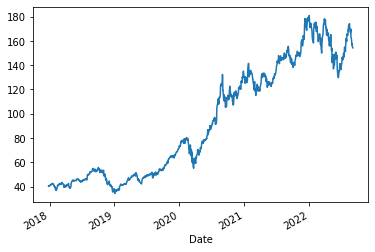

In [6]:
plot = data_target.plot()

In [7]:
#Check Length 
print("Length of Data:{}".format(len(data)))
print("Length of Data_Target:{}".format(len(data_target)))

Length of Data:1259
Length of Data_Target:1182


In [8]:
#Scaling Dataset
def scaledata(data_target):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    data_target_scaled = scaler.fit_transform(np.array(data_target).reshape(-1,1))
    #plot_scaled = pd.DataFrame(data_target_scaled).plot()
    print(data_target.shape)
    return data_target_scaled, scaler

In [9]:
data_target_scaled = scaledata(data_target)[0]
scaler = scaledata(data_target)[1]
data_target_scaled

(1182,)
(1182,)


array([[0.04254448],
       [0.04259307],
       [0.0433712 ],
       ...,
       [0.84138212],
       [0.82674556],
       [0.81803177]])

In [10]:
data_test_scaled = scaledata(data_test)[0]

(127,)


In [11]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):   
    x_patern = []
    y_price = []

    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        #print(len(row))
        x_patern.append(row)
        y = data_target_scaled[day,0]
        #print(y)
        y_price.append(y)
    
    x_patern,y_price = np.array(x_patern),np.array(y_price)
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)
    
    return x_patern,y_price

In [12]:
train_pattern = createPatternSet(data_target_scaled,steps=50)

In [13]:
x_train = train_pattern[0]
y_train = train_pattern[1]

In [14]:
x_train.shape

(1132, 50, 1)

In [15]:
y_train.shape

(1132,)

In [16]:
x_train

array([[[0.04254448],
        [0.04259307],
        [0.0433712 ],
        ...,
        [0.05360038],
        [0.05093108],
        [0.05403988]],

       [[0.04259307],
        [0.0433712 ],
        [0.04037228],
        ...,
        [0.05093108],
        [0.05403988],
        [0.05898785]],

       [[0.0433712 ],
        [0.04037228],
        [0.04528401],
        ...,
        [0.05403988],
        [0.05898785],
        [0.06182004]],

       ...,

       [[0.68618287],
        [0.70603363],
        [0.72907963],
        ...,
        [0.86466431],
        [0.84784938],
        [0.83634438]],

       [[0.70603363],
        [0.72907963],
        [0.72907963],
        ...,
        [0.84784938],
        [0.83634438],
        [0.84138212]],

       [[0.72907963],
        [0.72907963],
        [0.70039116],
        ...,
        [0.83634438],
        [0.84138212],
        [0.82674556]]])

In [17]:
class StocksPriceRNN():

    loss='mean_squared_error'
    batch_size=32
    neurons = 50
    model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        self.x_train = x_train
        self.y_train = y_train
        self.epoch = epoch
    
    def buildArchitecture(self,rnn=2,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                            activation='tanh',
                                            return_sequences = True,
                                            input_shape = (self.x_train.shape[1],1)))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        for i in range(rnn):
            StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = True))
            StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        #return sequense changed to false
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = False))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        for i in range(dense):
            StocksPriceRNN.model.add(tf.keras.layers.Dense(units=StocksPriceRNN.neurons,
                                            activation='tanh'))
        
        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()
    
    def compiler(self):
        opt= tf.keras.optimizers.Adam()
        StocksPriceRNN.model.compile(optimizer = opt,
                                    loss = StocksPriceRNN.loss)
        return StocksPriceRNN.model.summary()
        
    def modelfit(self):
        history = StocksPriceRNN.model.fit(self.x_train,self.y_train,
                                        epochs=self.epoch,batch_size=StocksPriceRNN.batch_size,validation_split=0.2,
                                       )
        return history
    
    def changeBatchSize(self,size):
        StocksPriceRNN.batch_size = size
        print("Changed!")
    def changeNeurons(self,size):
        StocksPriceRNN.neurons = size
        print("Changed!")
    def changeEpoch(self,size):
        self.epoch = size
        print("Changed!")

In [18]:
RNN1 = StocksPriceRNN(x_train,y_train,50)

In [19]:
RNN1.buildArchitecture(2,0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [20]:
RNN1.compiler()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [21]:
history = RNN1.modelfit()

Epoch 1/50
29/29 [==============================] - 6s 47ms/step - loss: 0.3713 - val_loss: 0.0063
Epoch 2/50
29/29 [==============================] - 1s 25ms/step - loss: 0.2837 - val_loss: 0.0026
Epoch 3/50
29/29 [==============================] - 1s 25ms/step - loss: 0.2171 - val_loss: 0.0040
Epoch 4/50
29/29 [==============================] - 1s 25ms/step - loss: 0.1770 - val_loss: 0.0357
Epoch 5/50
29/29 [==============================] - 1s 27ms/step - loss: 0.1353 - val_loss: 0.0121
Epoch 6/50
29/29 [==============================] - 1s 25ms/step - loss: 0.1170 - val_loss: 0.0150
Epoch 7/50
29/29 [==============================] - 1s 28ms/step - loss: 0.0890 - val_loss: 0.0085
Epoch 8/50
29/29 [==============================] - 1s 37ms/step - loss: 0.0698 - val_loss: 0.0175
Epoch 9/50
29/29 [==============================] - 1s 29ms/step - loss: 0.0596 - val_loss: 0.0074
Epoch 10/50
29/29 [==============================] - 1s 26ms/step - loss: 0.0562 - val_loss: 0.0060
Epoch 11/

In [46]:
RNN1.save("RNN.h5")

AttributeError: 'StocksPriceRNN' object has no attribute 'save'

In [22]:
test = data[len(data) - len(data_test) - 50:]
test = scaler.transform(test)

In [23]:
test_pattern = createPatternSet(test,steps=50)
x_test = test_pattern[0]
y_test = test_pattern[1]

In [24]:
#Predict the value for test set
y_test

array([0.72907963, 0.70039116, 0.71255989, 0.69549639, 0.71052033,
       0.72839978, 0.73764525, 0.76096324, 0.76565387, 0.75090181,
       0.75763201, 0.75511673, 0.77537547, 0.78693228, 0.76585801,
       0.79257486, 0.80644322, 0.82214712, 0.81358129, 0.80583142,
       0.79665378, 0.83193646, 0.8357436 , 0.87082224, 0.86402399,
       0.85382668, 0.89543189, 0.89325643, 0.8916907 , 0.88842294,
       0.88876329, 0.9181725 , 0.91306672, 0.93764234, 0.9450627 ,
       0.94397341, 0.95432107, 0.95159801, 0.9336939 , 0.9068037 ,
       0.90448903, 0.9065313 , 0.92355048, 0.8799133 , 0.86466431,
       0.84784938, 0.83634438, 0.84138212, 0.82674556, 0.81803177,
       0.8277668 , 0.81755533, 0.83736552, 0.87861987, 0.81333449,
       0.8233417 , 0.80332717, 0.79195847, 0.81769133, 0.83416591,
       0.8125176 , 0.80584609, 0.79012034, 0.79243501, 0.79917457,
       0.78610385, 0.73599951, 0.70686269, 0.73579526, 0.76064329,
       0.76268545, 0.75608209, 0.71972917, 0.72197569, 0.71217

In [25]:
x_test

array([[[0.92276064],
        [0.88807271],
        [0.8865794 ],
        ...,
        [0.68618287],
        [0.70603363],
        [0.72907963]],

       [[0.88807271],
        [0.8865794 ],
        [0.90239588],
        ...,
        [0.70603363],
        [0.72907963],
        [0.72907963]],

       [[0.8865794 ],
        [0.90239588],
        [0.90124198],
        ...,
        [0.72907963],
        [0.72907963],
        [0.70039116]],

       ...,

       [[0.71217273],
        [0.70781578],
        [0.73947152],
        ...,
        [0.68326149],
        [0.66866894],
        [0.66819167]],

       [[0.70781578],
        [0.73947152],
        [0.70808818],
        ...,
        [0.66866894],
        [0.66819167],
        [0.68967132]],

       [[0.73947152],
        [0.70808818],
        [0.73552307],
        ...,
        [0.66819167],
        [0.68967132],
        [0.66771429]]])

In [26]:
pred = RNN1.model.predict(x=x_test)
pred.shape

4/4 [==============================] - 1s 9ms/step


(127, 1)

In [27]:
#Transform back the inverse value

output = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))

In [28]:
output

array([[141.30266],
       [142.51324],
       [143.33981],
       [142.94328],
       [143.98787],
       [143.42418],
       [144.3283 ],
       [144.6997 ],
       [146.0178 ],
       [147.79947],
       [148.76213],
       [149.93918],
       [150.45605],
       [150.58694],
       [150.84254],
       [152.31636],
       [151.79784],
       [151.61316],
       [152.14764],
       [153.88869],
       [155.37268],
       [155.29442],
       [154.78877],
       [154.86871],
       [156.7067 ],
       [158.4272 ],
       [159.08635],
       [159.93172],
       [161.39297],
       [162.44286],
       [163.49786],
       [163.6442 ],
       [163.27472],
       [163.74246],
       [163.94962],
       [165.52704],
       [166.07861],
       [166.40053],
       [167.34995],
       [167.75421],
       [167.6013 ],
       [166.07713],
       [164.97562],
       [164.49165],
       [164.2732 ],
       [163.34718],
       [162.02216],
       [160.08517],
       [159.05678],
       [158.85832],


In [31]:
def plotting(org_vals,output):
    plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(org_vals,color="b",label="Org value")
    plt.plot(output,color="r",label="Predicted")
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

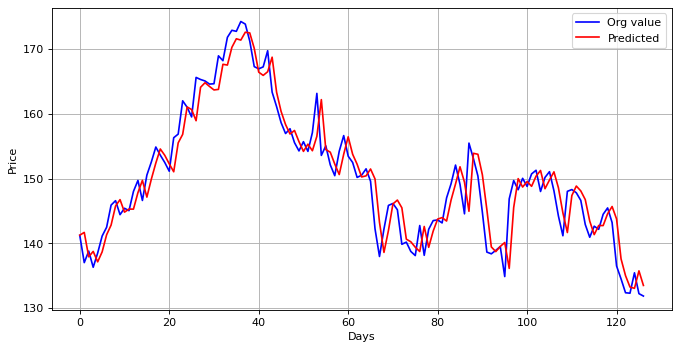

In [52]:
plotting(org_vals,output)

In [33]:
#Build a for loop with some iterations
for steps in [7,30,90]:
    for epoch in [20,30,50]:
        #prepare train data
        train_pattern = createPatternSet(data_target_scaled,steps=steps)
        #prepare test data
        test = data[len(data) - len(data_test) - steps:]
        test = scaler.transform(test)

        test_pattern = createPatternSet(test,steps=steps)
        x_test = test_pattern[0]
        y_test = test_pattern[1]
        #Build Model
        RNN1 = StocksPriceRNN(x_train,y_train,epoch)
        RNN1.buildArchitecture(2,0)
        RNN1.compiler()
        #fit model
        history = RNN1.modelfit()
        #Predict Values
        pred = RNN1.model.predict(x=x_test)
        output = scaler.inverse_transform(pred)
        
        #visualise
        print("Plotting for Steps {} and Epoch {}".format(steps,epoch))
        plotting(org_vals,output)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_5 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_6 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 50)               

ValueError: in user code:

    File "C:\Users\Chirag\anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Chirag\anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Chirag\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Chirag\anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Users\Chirag\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Chirag\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 50, 1), found shape=(None, 7, 1)


In [34]:
#Long Short Term Memory
class LstmModel(StocksPriceRNN):
    StocksPriceRNN.model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        super().__init__(x_train,y_train,epoch)
    
    def buildArchitecture(self,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.LSTM(StocksPriceRNN.neurons,input_shape=(None,1)))
        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()

In [35]:
LSTM = LstmModel(x_train,y_train,epoch=50)

In [36]:
LSTM.changeBatchSize(1)

Changed!


In [37]:
LSTM.changeNeurons(10)

Changed!


In [38]:
LSTM.buildArchitecture()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [39]:
LSTM.compiler()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = LSTM.modelfit()

Epoch 1/50
905/905 [==============================] - 10s 9ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 2/50
905/905 [==============================] - 8s 9ms/step - loss: 6.1683e-04 - val_loss: 0.0030
Epoch 3/50
905/905 [==============================] - 7s 8ms/step - loss: 5.3614e-04 - val_loss: 0.0043
Epoch 4/50
905/905 [==============================] - 8s 9ms/step - loss: 4.7631e-04 - val_loss: 0.0016
Epoch 5/50
905/905 [==============================] - 7s 8ms/step - loss: 4.2461e-04 - val_loss: 0.0034
Epoch 6/50
905/905 [==============================] - 7s 8ms/step - loss: 4.0157e-04 - val_loss: 0.0016
Epoch 7/50
905/905 [==============================] - 8s 8ms/step - loss: 3.7099e-04 - val_loss: 0.0010
Epoch 8/50
905/905 [==============================] - 8s 8ms/step - loss: 3.4820e-04 - val_loss: 0.0023
Epoch 9/50
905/905 [==============================] - 7s 8ms/step - loss: 3.2630e-04 - val_loss: 9.2042e-04
Epoch 10/50
905/905 [==============================] - 9s 10ms/

4/4 [==============================] - 1s 2ms/step


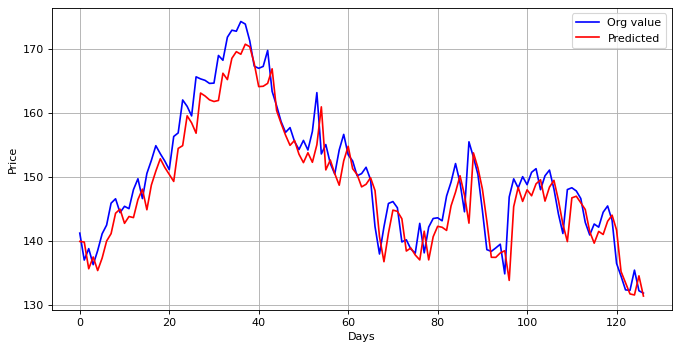

In [41]:
pred = LSTM.model.predict(x_test)
output = scaler.inverse_transform(pred)

plotting(org_vals,output)

In [55]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
train_predict = LSTM.model.predict(x_train)
test_predict = LSTM.model.predict(x_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

4/4 [==============================] - 0s 8ms/step
Train Mean Absolute Error: 1.5464502476129416
Train Root Mean Squared Error: 2.2213233880819394
Test Mean Absolute Error: 2.5883268821896506
Test Root Mean Squared Error: 3.3652034711069976


Changed!
Changed!
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32

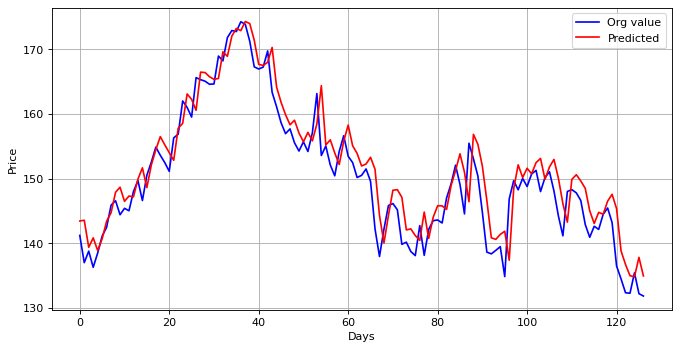

Changed!
Changed!
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 49

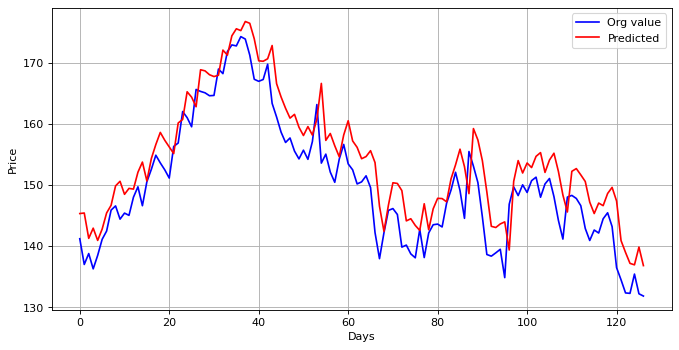

Changed!
Changed!
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12)                672       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12)                672       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 68

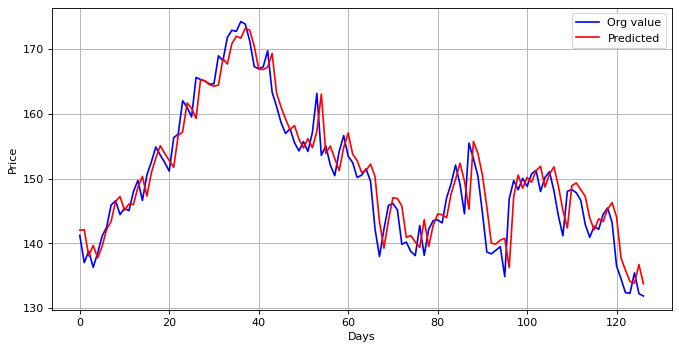

Changed!
Changed!
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 320       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 320       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32

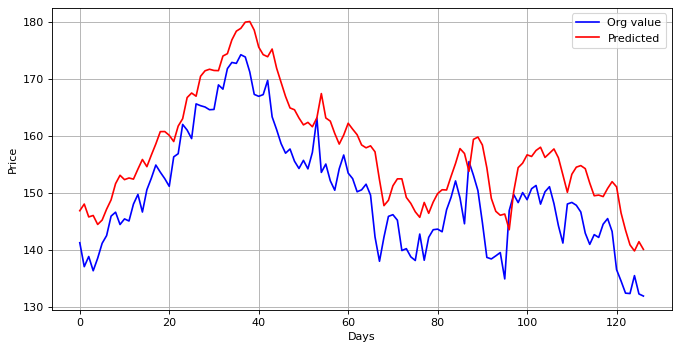

Changed!
Changed!
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                480       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                480       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 49

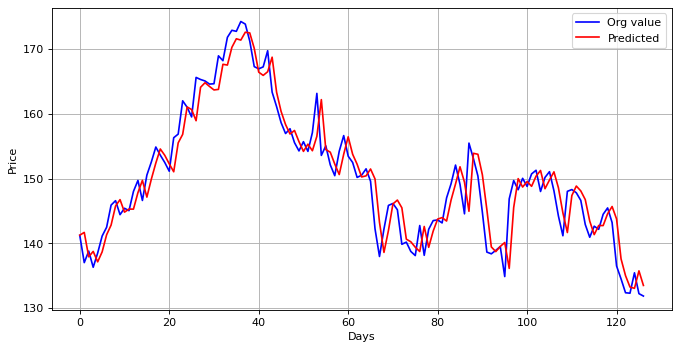

Changed!
Changed!
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12)                672       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12)                672       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 

KeyboardInterrupt: 

In [42]:
for epch in [60,100,200]:
    for batch in [2,4,6]:
        for neurons in [8,10,12]:
            LSTM2 = LstmModel(x_train,y_train,epoch=epch)
            LSTM2.changeBatchSize(batch)
            LSTM2.changeNeurons(neurons)

            LSTM2.buildArchitecture()
            LSTM2.compiler()
            history = LSTM2.modelfit()

            pred = LSTM2.model.predict(x_test)
            output = scaler.inverse_transform(pred)
            

            print("For epch {} and batch {}".format(epch,batch))
            plotting(org_vals,output)

Changed!
Changed!
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10)                480       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10)                480       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 

Epoch 63/200
453/453 [==============================] - 6s 14ms/step - loss: 1.7146e-04 - val_loss: 5.1616e-04
Epoch 64/200
453/453 [==============================] - 6s 14ms/step - loss: 1.6884e-04 - val_loss: 4.6475e-04
Epoch 65/200
453/453 [==============================] - 6s 14ms/step - loss: 1.7306e-04 - val_loss: 4.9107e-04
Epoch 66/200
453/453 [==============================] - 6s 14ms/step - loss: 1.6561e-04 - val_loss: 5.0477e-04
Epoch 67/200
453/453 [==============================] - 7s 14ms/step - loss: 1.7063e-04 - val_loss: 6.1235e-04
Epoch 68/200
453/453 [==============================] - 6s 14ms/step - loss: 1.7584e-04 - val_loss: 6.1180e-04
Epoch 69/200
453/453 [==============================] - 6s 14ms/step - loss: 1.7604e-04 - val_loss: 4.9113e-04
Epoch 70/200
453/453 [==============================] - 7s 15ms/step - loss: 1.6051e-04 - val_loss: 5.5090e-04
Epoch 71/200
453/453 [==============================] - 6s 14ms/step - loss: 1.6515e-04 - val_loss: 6.2971e-04
E

453/453 [==============================] - 6s 14ms/step - loss: 1.6478e-04 - val_loss: 4.7222e-04
Epoch 137/200
453/453 [==============================] - 6s 13ms/step - loss: 1.7035e-04 - val_loss: 5.4339e-04
Epoch 138/200
453/453 [==============================] - 6s 13ms/step - loss: 1.6075e-04 - val_loss: 6.2094e-04
Epoch 139/200
453/453 [==============================] - 6s 14ms/step - loss: 1.6582e-04 - val_loss: 7.1821e-04
Epoch 140/200
453/453 [==============================] - 7s 15ms/step - loss: 1.5777e-04 - val_loss: 4.4716e-04
Epoch 141/200
453/453 [==============================] - 6s 14ms/step - loss: 1.5860e-04 - val_loss: 5.6622e-04
Epoch 142/200
453/453 [==============================] - 6s 13ms/step - loss: 1.6153e-04 - val_loss: 4.9007e-04
Epoch 143/200
453/453 [==============================] - 6s 13ms/step - loss: 1.6705e-04 - val_loss: 6.3802e-04
Epoch 144/200
453/453 [==============================] - 6s 14ms/step - loss: 1.5651e-04 - val_loss: 5.4672e-04
Epoch 

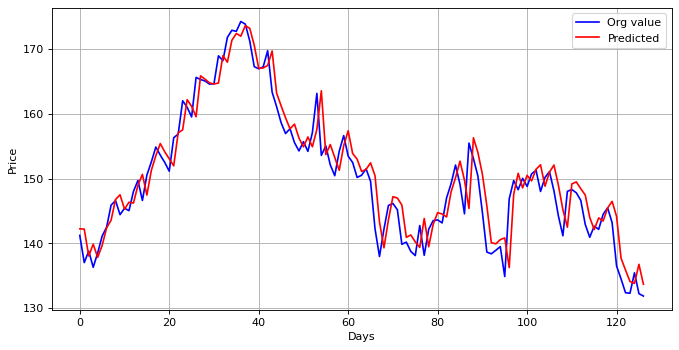

In [47]:
import warnings
warnings.filterwarnings('ignore')

#Final Model Output
#prepare train data
train_pattern = createPatternSet(data_target_scaled,steps=90)
test = data[len(data) - len(data_test) - 90:]
test = scaler.transform(test)
test_pattern = createPatternSet(test,steps=90)
x_test = test_pattern[0]
y_test = test_pattern[1]
LSTM2 = LstmModel(x_train,y_train,epoch=200)
LSTM2.changeBatchSize(2)
LSTM2.changeNeurons(10)

LSTM2.buildArchitecture()
LSTM2.compiler()
history = LSTM2.modelfit()
pred = LSTM2.model.predict(x_test)
pred = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))
print("For epch {}, neurons {} and batch {}".format(200,10,2))
plotting(org_vals,pred)

In [48]:
curr_data = yf.download('ESCORTS.NS',start="2021-02-1",end="2021-06-22",interval='1d')
print("Length of Data: ",len(curr_data))
curr_data = curr_data["Adj Close"]

def futurePrediciton1D(curr_data,start="2021-02-1",end="2021-06-19"):
    '''
    '''
    curr_scaled = scaledata(curr_data)[0]
    scaler = scaledata(curr_data)[1]
    
    #flatten into list
    x_data = list(curr_scaled.flatten())
    #convert into 3D
    x_data = np.array(x_data)
    x_data = x_data.reshape(1,len(x_data),1)
    
    #Predict
    nextDay = LSTM2.model.predict(x=x_data)
    nextDay = scaler.inverse_transform(nextDay.reshape(-1,1))

    nextDay = nextDay[-1][0]
    print("Prediction: {}".format(nextDay))
    
    #convert into dataframe again
    curr_data = pd.DataFrame(curr_data)
    curr_data.reset_index(inplace=True)
    adj_cl = curr_data[['Adj Close']]
    
    #concatenate new value
    adj_cl.loc[len(adj_cl.index)] = [nextDay]
    
    return adj_cl

[*********************100%***********************]  1 of 1 completed
Length of Data:  95


In [51]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(org_vals,output)
mse = metrics.mean_squared_error(org_vals,output)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(org_vals,output)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 2.545857587198572
MSE: 10.793579183185214
RMSE: 3.2853583036230942
R-Squared: 0.8946667221791216


(95,)
(95,)
1/1 [==============================] - 1s 510ms/step
Prediction: 1161.6153564453125


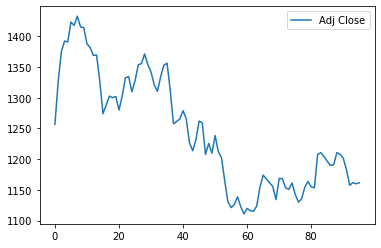

In [49]:
data = futurePrediciton1D(curr_data)
plot = data.plot()